# Описание проекта

Есть решение открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Решено обратиться к инвесторам. Их интересует текущее положение дел на рынке. Необходимо подготовить исследование рынка. Есть открытые данные о заведениях общественного питания в Москве.

Таблица rest_data:
 - id — идентификатор объекта;
 - object_name — название объекта общественного питания;
 - chain — сетевой ресторан;
 - object_type — тип объекта общественного питания;
 - address — адрес;
 - number — количество посадочных мест.

# Оглавление

[1. Изучение общей информации и предобработка](#step1)

[2. Анализ данных](#step2)

 - [Соотношение видов объектов общественного питания по количеству](#step2.1)

 - [Соотношение сетевых и несетевых заведений по количеству](#step2.2)

 - [Для какого вида объекта общественного питания характерно сетевое распространение?](#step2.3)

 - [Что характерно для сетевых заведений?](#step2.4)

 - [Среднее количество посадочных мест](#step2.5)

 - [График топ-10 улиц по количеству объектов общественного питания](#step2.6)

 - [Число улиц с одним объектом общественного питания](#step2.7)

 - [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#step2.8)

[3. Общий вывод](#step3)

[4. Ссылка на презетанцию](#step4)

## 1. Изучение общей информации и предобработка<a id="step1"></a> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
import re
from io import BytesIO
import requests
import warnings
warnings.filterwarnings("ignore")

Прочитаю файл с данными и изучу информацию в нем.

In [2]:
rest = pd.read_csv('/datasets/rest_data.csv')
pd.options.display.max_colwidth = 80
rest.sample(5)

,id,object_name,chain,object_type,address,number
13862,215873,Кафе,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 28",16
14654,205912,Суши пицца « Rock&Roll»,нет,кафе,"город Москва, Варшавское шоссе, дом 160",10
9161,160522,КАФЕ-КАРАОКЕ «La La Land»,нет,кафе,"город Москва, 2-й Донской проезд, дом 10",10
6538,23836,КП МГУ столовая 15,нет,столовая,"город Москва, территория Ленинские Горы, дом 1",200
8101,26443,Ичибан Боши,да,ресторан,"город Москва, улица Красная Пресня, дом 22",110


In [3]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В таблице содержится 15366 строк о заведениях общественного питания Москвы. Пропущенных значений нет, все столбцы имеют корректный тип данных.

In [4]:
print("Количество одинаковых id в данных = ", rest['id'].duplicated().sum())

Количество одинаковых id в данных =  0


В столбце object_name содержатся названия заведений. При просмотре нескольких строк датафрейма становится понятно, что названия заведений записаны не в едином формате. Поэтому приведу все названия к нижнему регистру, заменю "ё" на "е".

In [5]:
print("Количество уникальных названий в столбце object_name до обработки", rest['object_name'].value_counts().count())

Количество уникальных названий в столбце object_name до обработки 10393


Приведу все названия к нижнему регистру

In [6]:
rest['object_name'] = rest['object_name'].apply(lambda x:x.lower())

In [7]:
print("Количество уникальных названий в столбце object_name после приведения к нижнему регистру", rest['object_name'].value_counts().count())

Количество уникальных названий в столбце object_name после приведения к нижнему регистру 9924


Заменю "ё" на "е"

In [8]:
rest['object_name'] = rest['object_name'].apply(lambda x:x.replace('ё','е'))

In [9]:
print("Количество уникальных названий в столбце object_name после замены ё на е", rest['object_name'].value_counts().count())

Количество уникальных названий в столбце object_name после замены ё на е 9919


Количество уникальных названий заведений после обработки уменьшилось с 10393 до 9919.

In [10]:
print("Уникальные значения в столбце chain", rest['chain'].unique())

Уникальные значения в столбце chain ['нет' 'да']


In [11]:
print("Уникальные значения в столбце object_type", rest['object_type'].unique())

Уникальные значения в столбце object_type ['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']


Заменю названия некоторых типов на более короткие, чтобы удобнее было в дальнейшем подписывать графики. "Предприятие быстрого обслуживания" на "фастфуд", а "магазин (отдел кулинарии)" на "кулинария". 

In [12]:
rest['object_type'] = rest['object_type'].apply(lambda x:x.replace('предприятие быстрого обслуживания','фастфуд'))
rest['object_type'] = rest['object_type'].apply(lambda x:x.replace('магазин (отдел кулинарии)','кулинария'))

In [13]:
print("Уникальные значения в столбце object_type", rest['object_type'].unique())

Уникальные значения в столбце object_type ['кафе' 'столовая' 'закусочная' 'фастфуд' 'ресторан' 'кафетерий' 'буфет'
 'бар' 'кулинария']


In [14]:
rest['number'].describe()

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
max       1700.000000
Name: number, dtype: float64

Есть заведение с 1700 посадочных мест. На первый взгляд смущает, упорядочу таблицу по количеству посадочных мест. Посмотрю на заведения с наибольшим числом мест.

In [15]:
rest.sort_values(by='number', ascending = False).head(10)

,id,object_name,chain,object_type,address,number
12723,199696,arena by soho family,нет,бар,"город Москва, Кутузовский проспект, дом 36, строение 11",1700
8148,80291,банкетный зал шелк,нет,ресторан,"город Москва, Большой Саввинский переулок, дом 12, строение 10Г",1500
8345,27750,столовая-буфет,нет,столовая,"город Москва, улица Волхонка, дом 15",1400
9064,19719,комбинат питания «управление академсервис»,нет,столовая,"город Москва, проспект Вернадского, дом 84, строение 1",1288
4480,27024,рум сервис,нет,ресторан,"город Москва, Кутузовский проспект, дом 2/1, строение 1",1200
3686,27026,рум сервис,нет,ресторан,"город Москва, площадь Европы, дом 2",1200
2313,26560,ресторан «альфа»,нет,ресторан,"город Москва, Измайловское шоссе, дом 71, корпус А",1040
9955,171116,eataly,нет,ресторан,"город Москва, Киевская улица, дом 2",920
5649,29232,столовая московский гуманитарный университет,нет,столовая,"город Москва, улица Юности, дом 5, строение 1",760
13299,200905,white hall,нет,ресторан,"город Москва, Ферганская улица, дом 8",700


Более 1000 посадочных мест для банкетных залов и баров с концертным залом это норма. Например, "arena by soho family" - концертное агентство полного цикла, тОповое в России. Или "банкетный зал шелк" имеет 8 залов с разной посадкой от 20 до 400 мест, что в сумме дает 1500 мест.

In [16]:
print('Количество дубликатов в таблице rest = {:.0f}'.format(rest.duplicated().sum()))

Количество дубликатов в таблице rest = 0


### Итоги:
В таблице представлены достаточно чистые данные - пропусков нет, дублей тоже нет, все типы данных корректны, аномалий на этом этапе не выявлено. Всего есть информация о 9919 заведениях общественного питания Москвы, часть из которых является сетевыми, поэтому физически имеется 15366 точек. Для каждого заведения есть название, адрес, тип объекта, количество посадочных мест и является ли оно частью сети.

## 2. Анализ данных<a id="step2"></a> 

### Соотношение видов объектов общественного питания по количеству<a id="step2.1"></a> 

In [17]:
print("Количество уникальных видов объектов общественного питания =", len(rest['object_type'].unique()))

Количество уникальных видов объектов общественного питания = 9


Сгруппирую данные по типу объекта, подсчитав при этом количество заведений каждого типа. Также расчитаю процентное соотношение количества каждого типа к общему числу заведений.

In [18]:
type_counts = rest.groupby('object_type').agg({'id':'count'}).reset_index().rename(columns={'id':'counts'})
total_rests = type_counts['counts'].sum()
type_counts['%'] = (type_counts['counts'] *100 / total_rests).round(1)
type_counts = type_counts.sort_values(by='counts', ascending = False)
type_counts

,object_type,counts,%
3,кафе,6099,39.7
7,столовая,2587,16.8
6,ресторан,2285,14.9
8,фастфуд,1923,12.5
0,бар,856,5.6
1,буфет,585,3.8
4,кафетерий,398,2.6
2,закусочная,360,2.3
5,кулинария,273,1.8


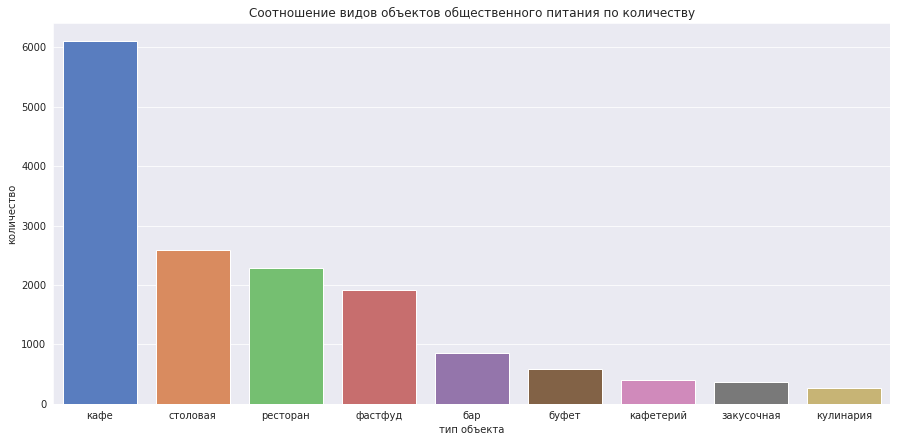

In [19]:
plt.figure(figsize=(15,7))
sns.set_palette('muted') 
sns.set_style("darkgrid")
sns.barplot(x='object_type', y='counts', data=type_counts)
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.xlabel('тип объекта')
plt.ylabel('количество')
plt.show()

Самый популярный вид объекта общественного питания это кафе - 6099 (39,7% от общего количества заведений), на втором, третьем и четвертом месте с небольшой разницей - 2587 столовых (16,8%), 2285 ресторанов (14,9%) и 1923 фастфудов (12,5%) соответственно. Баров менее 1000. А количество магазинов с отделом кулинарии всего 273, что состовляет менее 2% от общего числа заведений.

### Соотношение сетевых и несетевых заведений по количеству<a id="step2.2"></a> 

In [20]:
chains = rest.groupby('chain')['id'].count().reset_index().rename(columns={'id':'counts'})
chains['%'] = (chains['counts'] * 100 / chains['counts'].sum()).round(2)
chains

,chain,counts,%
0,да,2968,19.32
1,нет,12398,80.68


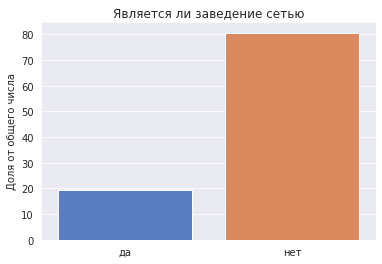

In [21]:
sns.barplot(x='chain',y='%', data=chains)
plt.title('Является ли заведение сетью')
plt.ylabel('Доля от общего числа')
plt.xlabel('')
plt.show()

Всего 19% заведений сетевые, остальные нет. Пора посмотреть какие виды заведений являются сетевыми.

### Для какого вида объекта общественного питания характерно сетевое распространение?<a id="step2.3"></a> 

In [22]:
object_chain = (rest
                .groupby(['object_type','chain'])['id'].count()
                .reset_index()
                .rename(columns={'id':'counts'})
                .merge(rest.groupby('object_type')['chain'].count(), on='object_type',suffixes=('','_total'))
               )
object_chain['%'] = round((object_chain['counts'] / object_chain['chain_total']) * 100)
object_chain

,object_type,chain,counts,chain_total,%
0,бар,да,37,856,4.0
1,бар,нет,819,856,96.0
2,буфет,да,11,585,2.0
3,буфет,нет,574,585,98.0
4,закусочная,да,56,360,16.0
5,закусочная,нет,304,360,84.0
6,кафе,да,1396,6099,23.0
7,кафе,нет,4703,6099,77.0
8,кафетерий,да,52,398,13.0
9,кафетерий,нет,346,398,87.0


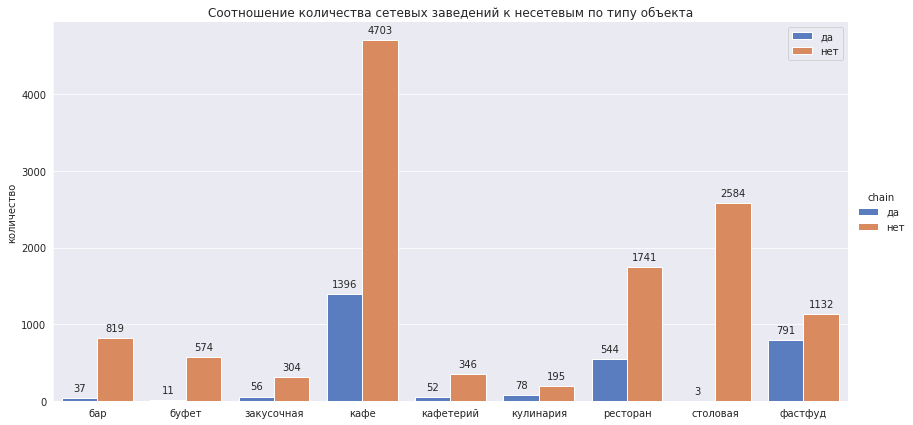

In [23]:
sns.set_style("darkgrid")
sns.set_palette('muted')
a = sns.catplot(kind="bar", data=object_chain,  x='object_type', y='counts', hue="chain", height=6, aspect=2)
plt.title('Соотношение количества сетевых заведений к несетевым по типу объекта')
plt.ylabel('количество')
plt.xlabel('')
plt.legend()

for ax in a.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

При рассмотрении заведений по типу объекта наибольшую долю сетевых составляют фастфуды (41%), на втором месте отделы кулинарии (29%), на третьем и четвертом рестораны (24%) и кафе (23%). Всего 3 сетевых столовых, 11 буфетов и 37 баров, для этих типов не характерно сетевое распространение.

### Что характерно для сетевых заведений?<a id="step2.4"></a> 

In [24]:
rest_new = rest[rest['chain'] == "да"]
chain_true_number = rest_new.groupby('object_type').agg({'number':'mean','id':'count'}).reset_index().rename(columns={'id':'counts'})
chain_true_number = chain_true_number.sort_values(by='number', ascending=False)
chain_true_number

,object_type,number,counts
7,столовая,112.333333,3
6,ресторан,100.233456,544
0,бар,53.027027,37
3,кафе,47.426934,1396
8,фастфуд,40.166877,791
2,закусочная,14.375000,56
1,буфет,12.727273,11
4,кафетерий,12.269231,52
5,кулинария,8.679487,78


Для кафе и предприятий быстрого обслуживания характерно большое количество точек при среднем количестве посадочных мест (40-50), у ресторанов меньше точек, но в 2 раза больше посадочных мест (100).

### Среднее количество посадочных мест<a id="step2.5"></a> 

In [25]:
chain_number = rest.groupby('object_type').agg({'number':'mean','id':'count'}).reset_index().rename(columns={'id':'counts'})
chain_number = chain_number.sort_values(by='number', ascending=False).round(0)
chain_number

,object_type,number,counts
7,столовая,130.0,2587
6,ресторан,97.0,2285
1,буфет,51.0,585
0,бар,43.0,856
3,кафе,40.0,6099
8,фастфуд,21.0,1923
4,кафетерий,9.0,398
2,закусочная,8.0,360
5,кулинария,6.0,273


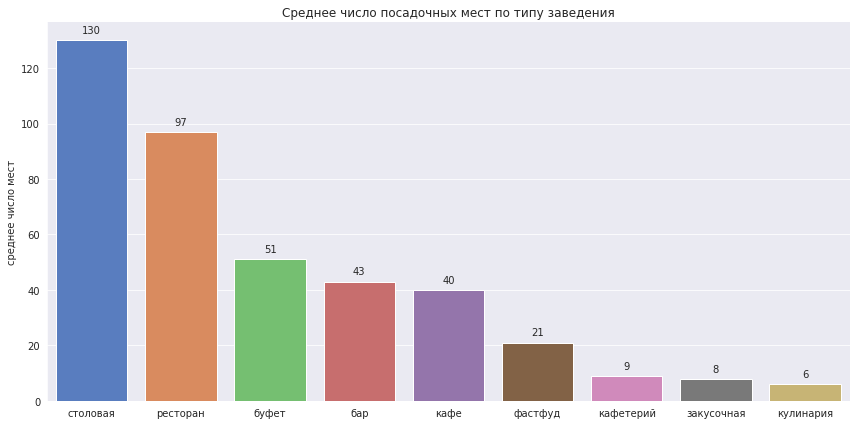

In [26]:
sns.set_style("darkgrid")
sns.set_palette('muted')
a = sns.catplot(kind="bar", data=chain_number,  x='object_type', y='number', height=6, aspect=2)
plt.title('Среднее число посадочных мест по типу заведения')
plt.ylabel('среднее число мест')
plt.xlabel('')

for ax in a.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Наибольшее количество посадочных мест предоставляют столовые и рестораны - в среднем 130 и 97 мест соответственно. Буфеты, бары и кафе имеют в среднем 51, 43 и 40 мест. В предприятиях быстрого обслуживания в среднем 21 место. Кафетерии, закусочные и магазины (отдел кулинарии) имеют наименьшее количество посадочных мест - в среднем 6-9 мест. 

### График топ-10 улиц по количеству объектов общественного питания<a id="step2.6"></a> 

Посмотрю еще раз как записан адрес в данных.

In [27]:
rest.sample(15)

,id,object_name,chain,object_type,address,number
10887,187538,bob's your uncle,нет,кафе,"город Москва, улица Маросейка, дом 4/2, строение 1",20
944,23844,шоколадница,да,кафе,"город Москва, Профсоюзная улица, дом 19",48
11557,178378,seafood factory,нет,кафе,"город Москва, улица Ленинская Слобода, дом 26",10
5528,154618,шаурма,нет,фастфуд,"город Москва, Сокольническая площадь, дом 4А",0
4741,28418,орс-нод-1 столовая 11,нет,столовая,"город Москва, Нижегородская улица, дом 28",45
6826,107314,кафе «теремок»,да,фастфуд,"город Москва, Дубравная улица, дом 34/29",45
8945,159060,кафе «райский уголок»,нет,кафе,"город Москва, Братеевская улица, дом 16, корпус 3",98
12462,26445,ресторан «караоке»,нет,кафе,"город Москва, улица Красная Пресня, дом 23, корпус Б, строение 1",96
1938,148068,бургерная хищник,нет,кафе,"город Москва, улица Кузнецкий Мост, дом 18/7",56
6633,19675,крошка картошка,да,фастфуд,"город Москва, Рублёвское шоссе, дом 62",40


Адреса представлены относительно корректно, представляют из себя наборы типа ГОРОД, УЛИЦА, дом и т.д., разделителем является запятая. Воспользуюсь методом str.split() и выделю улицу в отдельный столбец. Правда есть такие адреса, как "город Москва, город Троицк, микрорайон "В", дом 39", то есть по сути это не Москва. Так как исследование проводится на заведениях города Москвы, я исключу из анализа такие адреса.

In [28]:
rest['street'] = rest['address'].str.split(", ", n=2, expand=True)[1]
rest.sample(5)

,id,object_name,chain,object_type,address,number,street
6582,104251,white rabbite (белый кролик),да,ресторан,"город Москва, Смоленская площадь, дом 3",150,Смоленская площадь
6349,27180,эларджи,нет,ресторан,"город Москва, Гагаринский переулок, дом 15А",40,Гагаринский переулок
6173,59204,фаворит,нет,ресторан,"город Москва, Профсоюзная улица, дом 21А",120,Профсоюзная улица
11087,179364,кафе сабвей,нет,закусочная,"город Москва, Сигнальный проезд, владение 6А",10,Сигнальный проезд
11231,176768,кофе,нет,кафе,"город Москва, Большая Семёновская улица, дом 49А",2,Большая Семёновская улица


In [29]:
print("Количество адресов не в Москве = ", rest[rest['street'].str.match('город')==True]['street'].count())

Количество адресов не в Москве =  399


Убираю строки, где адрес не относится к Москве

In [30]:
rest = rest[rest['street'].str.match('город')==False].reset_index()

In [31]:
street_top10 = rest.groupby('street').agg({'id':'count'}).reset_index().rename(columns={'id':'counts'})
street_top10 = street_top10.sort_values(by='counts', ascending=False)[:10]
street_top10

,street,counts
1448,проспект Мира,204
993,Профсоюзная улица,182
683,Ленинградский проспект,171
979,Пресненская набережная,167
407,Варшавское шоссе,161
686,Ленинский проспект,147
1415,поселение Сосенское,138
1445,проспект Вернадского,132
674,Кутузовский проспект,114
600,Каширское шоссе,112


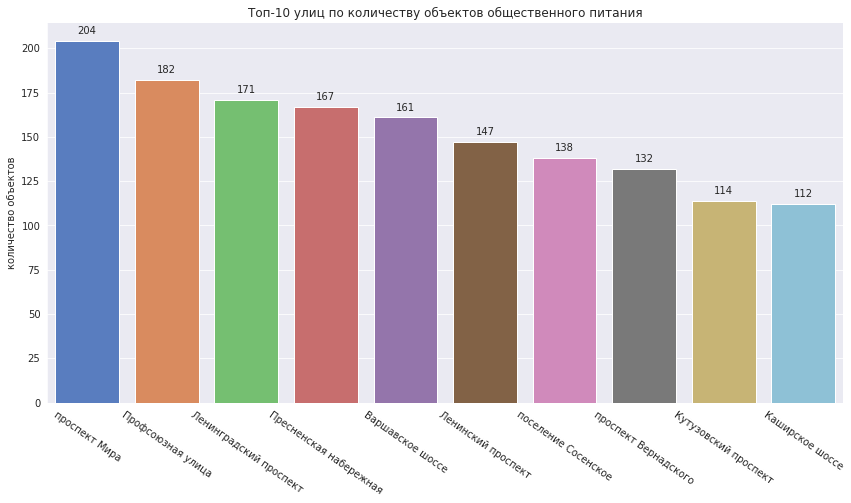

In [32]:
sns.set_style("darkgrid")
sns.set_palette('muted')
a = sns.catplot(kind="bar", data=street_top10,  x='street', y='counts', height=6, aspect=2)
plt.title('Топ-10 улиц по количеству объектов общественного питания')
plt.ylabel('количество объектов')
plt.xlabel('')
plt.xticks(rotation=-35)
for ax in a.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Больше всего объектов общественного питания расположено на проспекте Мира, что не удивительно, так как эта улица протяженностью около 9 км. На проспекте работают 204 объекта общественного питания. Профсоюзная улица немного уступает по количеству заведений 182, но не уступает в протяженности, но при этом располагается дальше от центра, чем проспект Мира. Замыкает топ-10 Каширское шоссе с количеством заведений равным 112.

Чтобы найти районы, к которым принадлежат улицы, воспользуюсь внешним источником https://hubofdata.ru/

In [33]:
district = pd.read_csv('http://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv')

In [34]:
district.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [35]:
district_and_street_top10 = pd.merge(street_top10, district, 
                                       left_on='street', right_on='streetname')
district_and_street_top10

,street,counts,streetname,areaid,okrug,area
0,проспект Мира,204,проспект Мира,70,СВАО,Алексеевский район
1,проспект Мира,204,проспект Мира,86,СВАО,Ярославский Район
2,проспект Мира,204,проспект Мира,78,СВАО,Район Марьина роща
3,проспект Мира,204,проспект Мира,79,СВАО,Останкинский район
4,проспект Мира,204,проспект Мира,81,СВАО,Район Ростокино
5,проспект Мира,204,проспект Мира,82,СВАО,Район Свиблово
6,проспект Мира,204,проспект Мира,16,ЦАО,Мещанский район
7,Профсоюзная улица,182,Профсоюзная улица,123,ЮЗАО,Академический район
8,Профсоюзная улица,182,Профсоюзная улица,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,182,Профсоюзная улица,134,ЮЗАО,Район Ясенево


Получилась таблица уже не из 10 строк, так как все улицы, кроме Пресненской набережной проходят через 2 и более района города Москвы. Посмотрю, какие районы встречаются чаще всего.

In [36]:
district_top = district_and_street_top10['area'].value_counts()
district_top.head(10)

Район Тропарево-Никулино      2
Обручевский район             2
Район Нагатино-Садовники      2
Район Гагаринский             2
Район Проспект Вернадского    2
Ломоносовский район           2
Район Теплый Стан             2
Донской район                 2
Район Якиманка                1
Район Ростокино               1
Name: area, dtype: int64

Можно выделить 8 районов, в которые входят топ-10 улиц с наибольшим количеством общественных заведений. Это такие районы как Гагаринский, Теплый Стан, Донской, Нагатино-Садовники, Тропарево-Никулино, Обручевский, Ломоносовский и Проспект Вернадского.

### Число улиц с одним объектом общественного питания<a id="step2.7"></a> 

In [37]:
one_object_streets = rest.pivot_table(index='street', values='object_name', aggfunc='count')
one_object_streets = one_object_streets.query('object_name == 1').reset_index()
one_object_streets.rename(columns={'object_name':'n_object'}, inplace=True)
print("Количество улиц с одним объектом общественного питания = ", one_object_streets['n_object'].count())

Количество улиц с одним объектом общественного питания =  579


Добавлю к этим улицам районы города

In [38]:
district_one_object_streets = pd.merge(one_object_streets, district, left_on='street', right_on='streetname')
district_one_object_streets.sample(10)

,street,n_object,streetname,areaid,okrug,area
472,улица Академика Опарина,1,улица Академика Опарина,129,ЮЗАО,Обручевский район
161,Брошевский переулок,1,Брошевский переулок,18,ЦАО,Таганский район
100,5-й Котельнический переулок,1,5-й Котельнический переулок,18,ЦАО,Таганский район
227,Козицкий переулок,1,Козицкий переулок,19,ЦАО,Тверской район
275,Мансуровский переулок,1,Мансуровский переулок,20,ЦАО,Район Хамовники
205,Жуков проезд,1,Жуков проезд,14,ЦАО,Район Замоскворечье
207,Заводской проезд,1,Заводской проезд,27,ВАО,Район Измайлово
396,Тессинский переулок,1,Тессинский переулок,18,ЦАО,Таганский район
11,1-й Коптельский переулок,1,1-й Коптельский переулок,16,ЦАО,Мещанский район
156,Большой Трёхсвятительский переулок,1,Большой Трёхсвятительский переулок,13,ЦАО,Басманный район


Выведу топ-10 районов по количеству улиц с одним заведением общественного питания

In [39]:
district_one_object_streets['area'].value_counts().head(10)

Таганский район        27
Район Хамовники        26
Басманный район        25
Тверской район         20
Пресненский район      19
Район Марьина роща     18
Район Арбат            17
Мещанский район        16
Район Сокольники       15
Район Замоскворечье    14
Name: area, dtype: int64

Наибольшее количество улиц (более 20) с одним объектом общественного питания находится в Таганском районе, Хамовники и в Басманском районе.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания<a id="step2.8"></a> 

In [40]:
street_top10 = street_top10['street']
rest_street_top10 = rest.query('street in @street_top10')

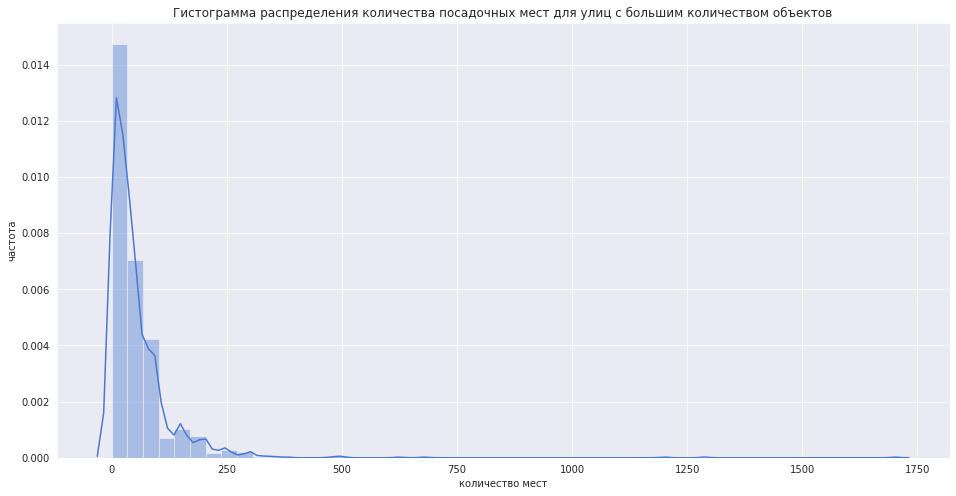

In [41]:
plt.figure(figsize=(16,8))
ax = sns.distplot(rest_street_top10['number'], bins = 50, kde=True)
plt.title("Гистограмма распределения количества посадочных мест для улиц с большим количеством объектов")
plt.ylabel('частота')
plt.xlabel('количество мест')
plt.show()

Основая часть значений находится в диапазоне от 0 до 250 посадочных мест. Нулевые значения связаны с наличием фастфудов и кулинарий. Много значений до 100 посадочных мест, это значит, что на топ-10 улицах много небольших заведений. Также справа наблюдаем длинный хвост, который растягивается до 1700, потому что заведение с самым большим количеством мест "arena by soho family" находится на Кутузовском проспекте, который попал в топ-10 улиц.

Теперь отброшу нулевое количество мест и более 250 и снова построю гистограмму распределения

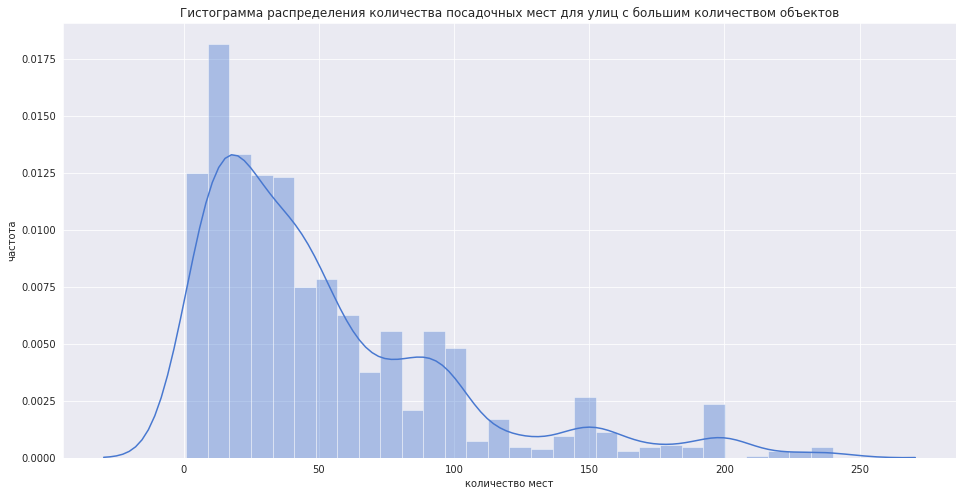

In [42]:
plt.figure(figsize=(16,8))
sns.distplot(rest_street_top10.query('number > 0 and number < 250')['number'], bins = 30, kde=True)
plt.title("Гистограмма распределения количества посадочных мест для улиц с большим количеством объектов")
plt.ylabel('частота')
plt.xlabel('количество мест')
plt.show()

Большинство заведений, находящихся на топ-10 улицах, имеют до 40 посадочных мест.

## 3. Общий вывод<a id="step3"></a> 

В ходе проведенного анализа мною получены следующие результаты:

- Лидирующее место в Москве занимают кафе. На втором месте - столовые, фастфуды и рестораны. А бары, буфеты, кафетерии и кулинарии являются наименее распространёнными видами общественного питания.

- Несетевых заведений значительно больше. Для столовых не характерно сетевое распространение. В таких типах заведениях как фастфуд, ресторан и кафе количество несетевых заведений превышает количество сетевых. Почти на каждую точку фастфуда приходится сетевое фастфуд заведение. Сетевое распространение более характерно для таких объектов общественного питания как фастфуд, кафе и ресторан.

- Для сетевых заведений характерно большое число точек с небольшим количеством посадочных мест. 

- Наибольшее среднее количество посадочных мест в столовых и ресторанах. Меньше всего посадочных мест в кафетериях, закусочных и кулинариях.

- Больше всего объектов общественного питания расположено на проспекте Мира, Профсоюзной улице, Ленинградском проспекте, Пресненской набережной и Варшавском шоссе.

- Чаще всего заведения встречаются в таких районах как Ломоносовский, Обручевский, Теплый Стан, Проспект Вернадского, Нагатино-Садовники, Гагаринский, Тропарево-Никулино и Донской.

- Улицы с одним объектом общественного питания в основном находятся в таких районах как Таганский, Хамовники, Басманный, Тверской и другие.

- На улицах с максимальных количеством заведений преобладают кафе и фастфуды, которые имеют от 10 до 40 посадочных мест.

Исходя из полученных данных, можно рекомендовать для нового заведения: тип - кафе, число посадочных мест от 10 до 40. Для новой точки с необычным типом обслуживания нет смысла делать сетевое заведение, так как формат новый и стоит его обточить. Не стоит сразу делать ресторан с большой вместимостью, ведь мы не знаем насколько хорошо взлетит новый формат, поэтому тип кафе и среднее число посадочных мест вполне уместно в данном случае. Несмотря на высокую конкуренцию, заведение лучше открывать на улицах, расположенных внутри МКАДА, так как там высокий трафик туристов и местных жителей, что должно привлечь внимание нового формата заведения.

## 4. Ссылка на презентацию<a id="step4"></a> 

https://drive.google.com/file/d/1FDG8CgIthU_Qbi-EfYKIfyR61zvaC_Pd/view?usp=sharing